In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.rdMolAlign import *
from rdkit.Chem.rdForceFieldHelpers import *
import copy 

In [2]:
# This is the rdkit ConstrainedEmbed function from AllChem
# Have edited to make it a bit shorter by deleting the instructions 
def MultiConstrainedEmbed(mol,core,useTethers=True,coreConfId=-1,
                          randomseed=2342):
    
    # In original constrained function, only a single match was found.
    # Here we look for multiple matches
    matches = mol.GetSubstructMatches(core, uniquify=False)
    if not matches:
        raise ValueError("molecule doesn't match the core")
        
    mols = []
    
    i = 0
    
    # Let's do exactly what the original function did but loop
    # over our matches 
    for match in matches:
        
        new_mol = mol
        
        coordMap={}
        coreConf = core.GetConformer(coreConfId)
        
        for i,idxI in enumerate(match):
            corePtI = coreConf.GetAtomPosition(i)
            coordMap[idxI]=corePtI

        ci = AllChem.EmbedMolecule(new_mol,coordMap=coordMap,randomSeed=randomseed)
        
        if ci<0:
            raise ValueError('Could not embed molecule.')
        
        algMap=[(j,i) for i,j in enumerate(match)]
        
        if not useTethers:
            # clean up the conformation
            ff = UFFGetMoleculeForceField(new_mol,confId=0)
            for i,idxI in enumerate(match):
                for j in range(i+1,len(match)):
                    idxJ = match[j]
                    d = coordMap[idxI].Distance(coordMap[idxJ])
                    ff.AddDistanceConstraint(idxI,idxJ,d,d,100.)
            ff.Initialize()
            n=4          
            more=ff.Minimize()
            while more and n:
                more=ff.Minimize()
                n-=1
            # rotate the embedded conformation onto the core:
            rms =AlignMol(new_mol,core,atomMap=algMap)
           
        else:
            # rotate the embedded conformation onto the core:
            rms = AlignMol(new_mol,core,atomMap=algMap)
            ff =  UFFGetMoleculeForceField(new_mol,confId=0)
            conf = core.GetConformer()
            for i in range(core.GetNumAtoms()):
                p =conf.GetAtomPosition(i)
                pIdx=ff.AddExtraPoint(p.x,p.y,p.z,fixed=True)-1
                ff.AddDistanceConstraint(pIdx,match[i],0,0,100.)
            ff.Initialize()
            n=4
            more=ff.Minimize(energyTol=1e-4,forceTol=1e-3)
            while more and n:
                more=ff.Minimize(energyTol=1e-4,forceTol=1e-3)
                n-=1
            # realign
            rms = AlignMol(new_mol,core,atomMap=algMap)

        new_mol.SetProp('EmbedRMS',str(rms))
        mols.append(new_mol)
        
    # Return a list of mols
    return mols

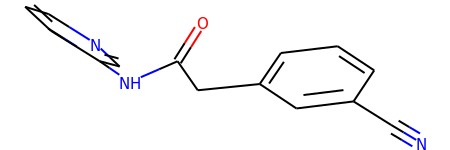

In [3]:
# Lets play around with substructure matching first
mol_1 = Chem.MolFromMolFile("data/compounds/x2600.mol")
mol_1

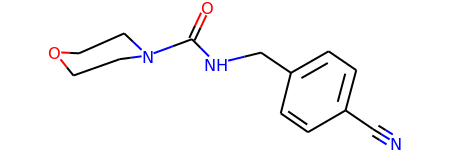

In [4]:
frag_mol = Chem.MolFromMolFile("data/frag_mols/x1249.mol")
frag_mol

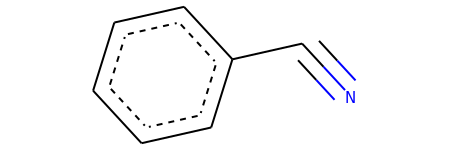

In [5]:
# Let's get a core that passes MCS between frag and designed mol
mcs = rdFMCS.FindMCS([frag_mol, mol_1], completeRingsOnly=True, matchValences=True)
patt = Chem.MolFromSmarts(mcs.smartsString,mergeHs=True)
patt

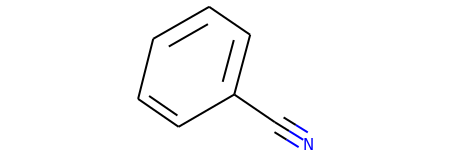

In [6]:
# Let's sort out the core 
replaced = AllChem.ReplaceSidechains(frag_mol, patt)
core = AllChem.DeleteSubstructs(replaced, Chem.MolFromSmiles('*'))
core.UpdatePropertyCache()
core

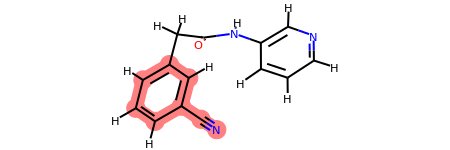

In [7]:
# Lets' look at substructure output
# First add H's to compound molmol.GetConformer().GetAtomPosition(0)
mol_1 = Chem.AddHs(mol_1)
test = MultiConstrainedEmbed(mol_1, core)
test[0]

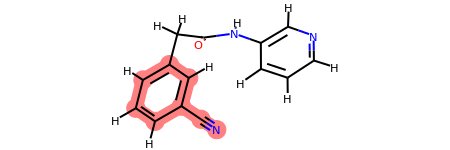

In [8]:
test[1]

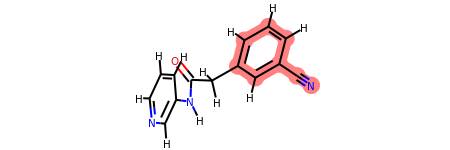

In [9]:
# Ok but is this what we'd expect if we used the original 
# constrainedembed function?
test_orig_func = AllChem.ConstrainedEmbed(mol_1, core)
test_orig_func

In [10]:
# Helper function (Thanks Tim) for assigning atom ids
# for drawing structures
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

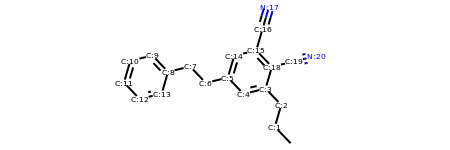

In [11]:
# Let's do some sanity checks
# First let's see what the rdkit GetSubstructMatch vs GetSubstructMatches outputs?
test_mol = Chem.MolFromSmiles("CCCC1=CC(CCC2=CC=CC=C2)=CC(C#N)=C1C#N")
mol_with_atom_index(test_mol)

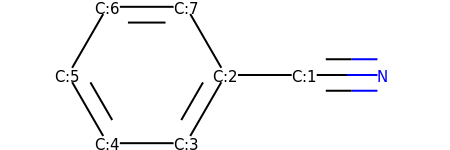

In [12]:
# Let's compare the test mol to a test fragment
test_frag = Chem.MolFromSmiles("N#CC1=CC=CC=C1")
mol_with_atom_index(test_frag)

In [13]:
# Ok so for a substructure search, we'd ideally want to get
# two matches that takes into account the symmetry of the test mol
# The original ConstrainedEmbed function only searches for
# one match using the GetSubstructMatch call
orig_constrained_matches = test_mol.GetSubstructMatch(test_frag)
orig_constrained_matches

(17, 16, 15, 14, 5, 4, 3, 18)

In [14]:
# The output above are the atom ids of the test mol that was 
# matched with the test frag. But what about the other side?
multi_constrained_matches = test_mol.GetSubstructMatches(test_frag, uniquify=False)
multi_constrained_matches

((17, 16, 15, 14, 5, 4, 3, 18),
 (17, 16, 15, 18, 3, 4, 5, 14),
 (20, 19, 18, 3, 4, 5, 14, 15),
 (20, 19, 18, 15, 14, 5, 4, 3))

In [15]:
# We got four matches and the ids match what we would expect
# But now let's look at a more concrete example where we use the 
# MultiConstrainedEmbed function defined avove
# Lets generate a conformer of the test mol 
AllChem.EmbedMolecule(test_mol,randomSeed=0xf00d)

0

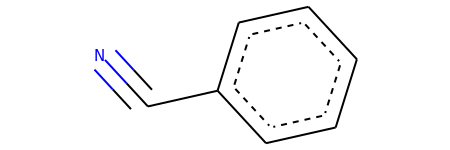

In [16]:
# Let's get a core that passes MCS between frag and above multi test mol
mcs = rdFMCS.FindMCS([test_frag, test_mol], completeRingsOnly=True, matchValences=True)
patt = Chem.MolFromSmarts(mcs.smartsString,mergeHs=True)
patt

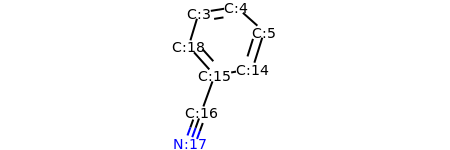

In [17]:
# Let's sort out the core 
replaced = AllChem.ReplaceSidechains(test_mol, patt)
core = AllChem.DeleteSubstructs(replaced, Chem.MolFromSmiles('*'))
core.UpdatePropertyCache()
core

In [18]:
# Lets' look at substructure output
# First add H's to compound mol
test_molh = Chem.AddHs(test_mol)

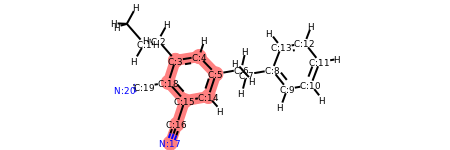

In [19]:
# Let's test original contrained function
test_orig = AllChem.ConstrainedEmbed(test_molh, core)
test_orig

In [20]:
# Let's test multi contrained function
test_multi = MultiConstrainedEmbed(test_molh, core)

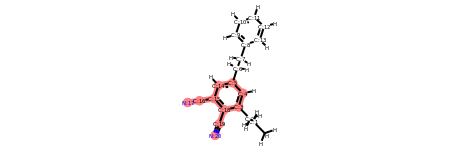

In [21]:
test_multi[0]

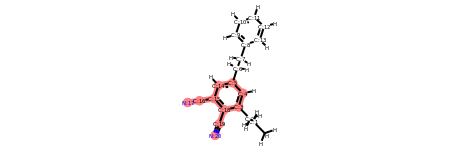

In [22]:
test_multi[1]

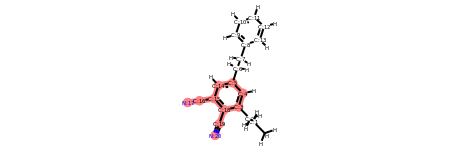

In [23]:
test_multi[2]

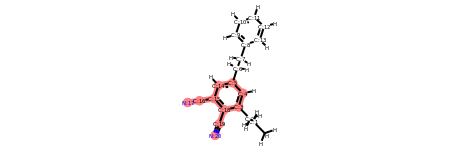

In [24]:
test_multi[3]